In [ ]:
# !pip install -r requirements.txt

In [4]:
# load libraries
import pandas  as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [5]:
# load data from assets folder
path = 'assets/'
train  = pd.read_csv(path + 'clean_sentiment.csv')
# test   = pd.read_csv(path + 'test.csv')

In [6]:
# inspect training data
train.head()

,id,text,labels
0,0,team merimera alikuwa takataka,0
1,1,sijafurahishwa,0
2,2,kubuni dosari,0
3,3,bila kusema nilipoteza pesa zangu,0
4,4,sema kupoteza pesa na wakati,0


In [8]:
train['comment'] = train['text']
train['sentiment'] = train['labels']

<AxesSubplot:>

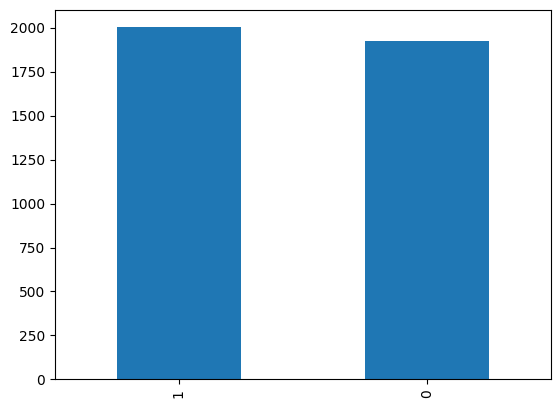

In [9]:
# plot count of sentiments
train.sentiment.value_counts().plot(kind='bar')

In [11]:
# data cleaning

# Remove duplicate rows
train = train.drop_duplicates()

In [12]:
# Remove rows with missing values
train = train.dropna()

In [13]:
import re

def clean_text(text):
    # Remove special characters, punctuation, and non-Swahili characters
    text = re.sub(r"[^a-zA-Z0-9 \-]", "", text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove HTML tags (if available)
    text = re.sub(r"<.*?>", "", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # remove numbers
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) 
    text = re.sub(r"\d", "", text)
    # set in lowercase
    text = text.lower()   
    
    # Remove consecutive duplicate characters (e.g., 'loooove' to 'love')
    text = re.sub(r"(.)\1+", r"\1", text)
    
    return text

# Apply text cleaning to the 'text' column
train['comment'] = train['comment'].apply(clean_text)

In [14]:
train.head() # preview data again

,id,text,labels,comment,sentiment
0,0,team merimera alikuwa takataka,0,team merimera alikuwa takataka,0
1,1,sijafurahishwa,0,sijafurahishwa,0
2,2,kubuni dosari,0,kubuni dosari,0
3,3,bila kusema nilipoteza pesa zangu,0,bila kusema nilipoteza pesa zangu,0
4,4,sema kupoteza pesa na wakati,0,sema kupoteza pesa na wakati,0


In [15]:
train = train.sample(frac=1, random_state=42)

# Split the dataset into train and test sets
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Select 80% of each sentiment class for training
for sentiment in [-1, 0, 1]:
    sentiment_data = train[train['sentiment'] == sentiment]
    n_samples = int(0.8 * len(sentiment_data))
    train_data = train_data.append(sentiment_data[:n_samples])
    test_data = test_data.append(sentiment_data[n_samples:])

# Shuffle the train and test sets again
train_data = train_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)


C:\Users\Edgar\AppData\Local\Temp\ipykernel_9236\388942368.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(sentiment_data[:n_samples])
C:\Users\Edgar\AppData\Local\Temp\ipykernel_9236\388942368.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(sentiment_data[n_samples:])
C:\Users\Edgar\AppData\Local\Temp\ipykernel_9236\388942368.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(sentiment_data[:n_samples])
C:\Users\Edgar\AppData\Local\Temp\ipykernel_9236\388942368.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data

In [16]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Specify the maximum number of words to be used
max_sequence_length = 64
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(train_data['comment'])

# Convert training texts to sequences of tokens
train_sequences = tokenizer.texts_to_sequences(train_data['comment'])
# Pad training sequences to ensure uniform length
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

# Convert testing texts to sequences of tokens
test_sequences = tokenizer.texts_to_sequences(test_data['comment'])
# Pad testing sequences to ensure uniform length
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)


In [17]:
vocab_size = len(tokenizer.word_index) + 1

test_data.head()

,id,text,labels,comment,sentiment
1901,1901,simu tamu zaidi,1,simu tamu zaidi,1
2964,2964,huduma hunyonya,0,huduma hunyonya,0
3809,3809,katika pindi tatu tofauti tofauti mimi niliom...,0,katika pindi tatu tofauti tofauti mimi niliomb...,0
3450,3450,vivyo hivyo mtu aliyejifungua hakusema juu ya ...,0,vivyo hivyo mtu aliyejifungua hakusema ju ya k...,0
1971,1971,hadithi yenyewe ni yenye kutabirika na yenye u...,0,hadithi yenyewe ni yenye kutabirika na yenye u...,0


In [50]:
num_classes = 2  # Number of sentiment classes
sentiment_mapping = [0, 1]

# Convert the sentiment labels to one-hot encoded vectors for training data
train_one_hot_labels = np.zeros((len(train_data), num_classes))
for i, sentiment in enumerate(train_data['sentiment']):
    index = sentiment_mapping[sentiment]
    train_one_hot_labels[i, index] = 1

# Convert the sentiment labels to one-hot encoded vectors for testing data
test_one_hot_labels = np.zeros((len(test_data), num_classes))
for i, sentiment in enumerate(test_data['sentiment']):
    index_ = sentiment_mapping[sentiment]
    test_one_hot_labels[i, index_] = 1


In [52]:
test_padded_sequences.shape, train_padded_sequences.shape, train_one_hot_labels.shape, test_one_hot_labels.shape

((785, 64), (3136, 64), (3136, 2), (785, 2))

In [51]:
train_one_hot_labels[2] 

array([1., 0.])

In [53]:
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Define the hypermodel
class SentimentAnalysisHyperModel(HyperModel):
    def __init__(self, vocab_size, max_sequence_length, small=False):
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.small = small
    
    def build(self, hp):
        model = Sequential()
        if not self.small:
            model.add(Embedding(self.vocab_size, 136, input_length=self.max_sequence_length))
            model.add(LSTM(128, return_sequences=True))
            model.add(LSTM(102))
            model.add(Dense(hp.Int('layer_units', min_value=96, max_value=128, step=32), activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(3, activation='softmax'))
        else:
            model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
            model.add(Bidirectional(LSTM(hp.Int('layer_units', min_value=96, max_value=128, step=32), dropout=0.2, recurrent_dropout=0.2)))
            model.add(Dense(3, activation='softmax'))
            
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(1e-4),
            metrics=['accuracy']
        )
        return model

    def build_model(self, hp=128):
        model = Sequential()
        if not self.small:
            model.add(Embedding(self.vocab_size, 136, input_length=self.max_sequence_length))
            model.add(LSTM(128, return_sequences=True))
            model.add(LSTM(102))
            model.add(Dense(96, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(3, activation='softmax'))
        else:
            model.add(Embedding(len(tokenizer.word_index) + 1, 136, input_length=max_sequence_length))
            model.add(LSTM(hp, dropout=0.2, recurrent_dropout=0.2))
            model.add(Dense(3, activation='softmax'))
            
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(1e-4),
            metrics=['accuracy']
        )
        return model




In [54]:
# USE WHEN HYPER PARAMETERS ARE NOT WELL DEFINED

# Define the hyperparameters search space
hypermodel = SentimentAnalysisHyperModel(vocab_size, max_sequence_length, False)
hyperparameters = HyperParameters()
hyperparameters.Int('layer_units', min_value=96, max_value=128, step=32)

# Perform random search hyperparameter tuning
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparameter_tuning',
    project_name='swahili_sentiment_analysis_sarufi'
)

tuner.search(train_padded_sequences, train_one_hot_labels, validation_data=(test_padded_sequences, test_one_hot_labels), batch_size=4, epochs=2)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

Trial 2 Complete [00h 00m 02s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 05s
INFO:tensorflow:Oracle triggered exit


In [55]:
model = Sequential()
model.add(Embedding(vocab_size, 136, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(102))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 64, 136)           865912    
                                                                 
 lstm_4 (LSTM)               (None, 64, 128)           135680    
                                                                 
 lstm_5 (LSTM)               (None, 102)               94248     
                                                                 
 dense_4 (Dense)             (None, 96)                9888      
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 194       
                                                                 
Total params: 1,105,922
Trainable params: 1,105,922
No

In [65]:
history = model.fit(train_padded_sequences, train_one_hot_labels, validation_data=(test_padded_sequences, test_one_hot_labels), batch_size=4, epochs=10)

Epoch 1/10
784/784 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5526

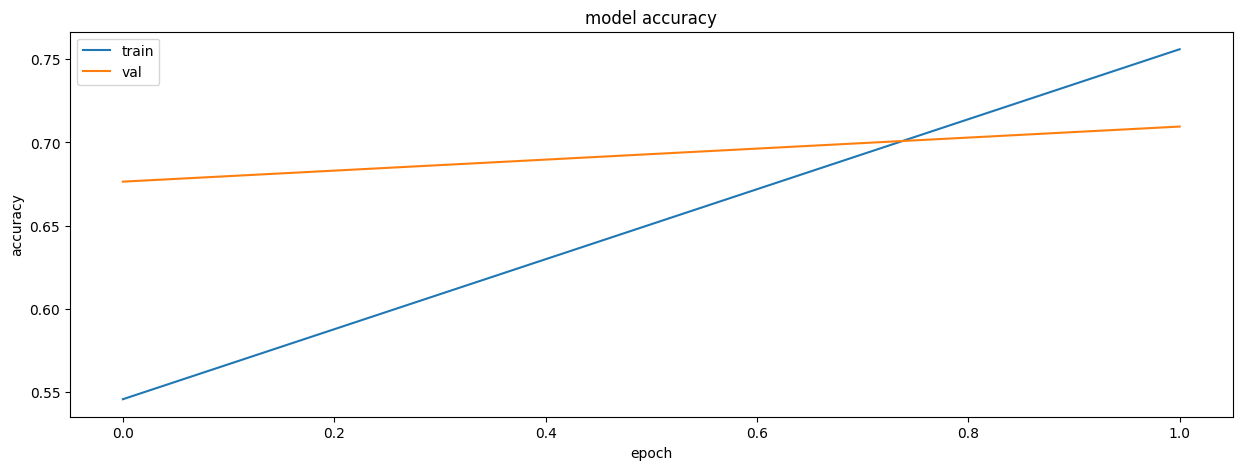

In [ ]:
# plot accuracy and loss on training and validation sets
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


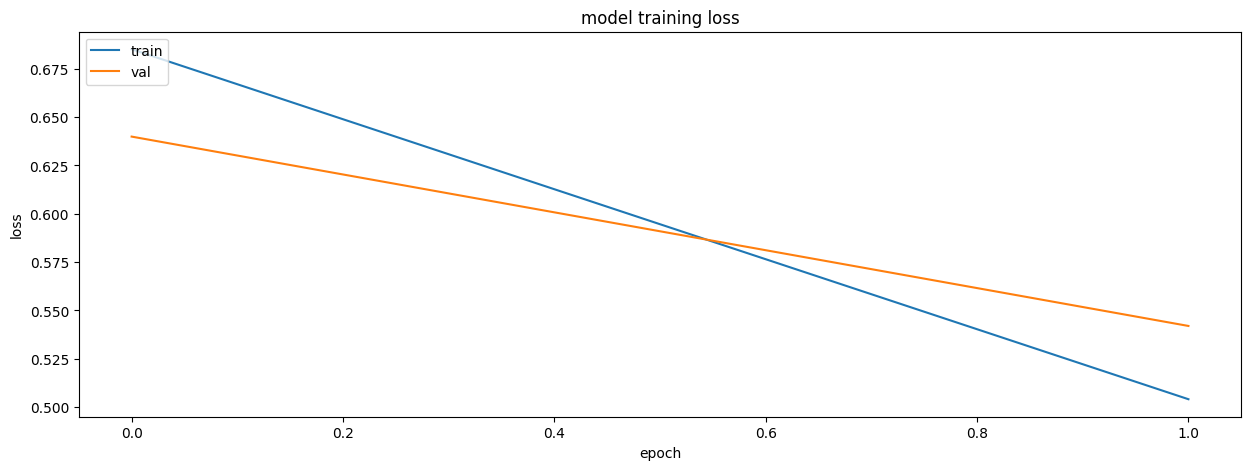

In [ ]:
# plot accuracy and loss on training and validation sets
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [56]:
best_model = model  # switched to custom

In [60]:
def classify(text, model, tokenizer, max_sequence_length):
    text = clean_text(text)
    # tokenize and pad text
    text_sequences = tokenizer.texts_to_sequences([text])
    # Pad training sequences to ensure uniform length
    text_padded_sequences = pad_sequences(text_sequences, maxlen=max_sequence_length)
    predicted_sentiment = model.predict(text_padded_sequences, verbose=0)

    # Convert the prediction probabilities to sentiment labels
    sentiment_labels = { 0: "Negative", 1: "Positive"} 
    predicted_result = sentiment_labels[int(np.argmax(predicted_sentiment))]

    return predicted_result, predicted_sentiment

In [64]:
msg = "nyinyi mimi nilinunua laini yenu miaka  iliyopita hata peremende sijawai pata gai hata mtu akioa bibi miaka hiyo yote sianamzaliaheeeee nengereni cia maitho kari gani"
sentiment_result = classify(msg, best_model, tokenizer, max_sequence_length)
sentiment_result

('Positive', array([[0.49696496, 0.50303507]], dtype=float32))

In [44]:
# save the model
best_model.save("model/hyper_sarufi_tunned_swahili_sentiment_rating.h5")

#save tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizers/hyper_sarufi_tunned_swahili_sentiment_rating.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [45]:
train['labels'] = train['comment'].apply(lambda x: classify(x, best_model, tokenizer, max_sequence_length))

KeyError: 2

<AxesSubplot:>

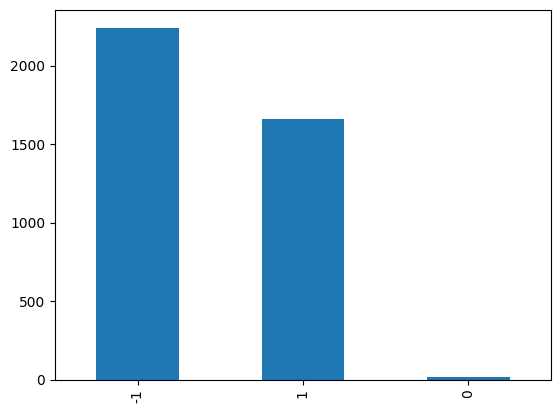

In [35]:
train.label.value_counts().plot(kind='bar')